# Portland Dungeon May 2017 #
This notebook documents work for the May 2017 Portland Dungeon Hackfest

### Goals
* Compare the vtune profiles of DESI spectral extraction code on
  Haswell vs. KNL to understand why per-core Haswell performance
  is 6-8x better than KNL (instead of ~2-3x)
* Identify KNL-specific hotspots
* Fix KNL-specific hotspots in order to achieve node parity between KNL and Haswell when parallelizing over multiple cores.

## Background

These benchmarks test the DESI spectral extraction code,
which is the most computationally intensive portion of our
data processing pipeline.  It performs a forward modeling analysis
of astronomical spectra projected onto 2D CCD images.

Each DESI "frame" has 500 spectra with ~4000 wavelengths each.
The extraction problem is subdivided into many sub-extractions
of $n$ spectra by $m$ wavelengths, where each sub-extraction involves
eigendecomposition of a $(n m \times nm)$ maxtrix.
The optimal choice of $n$ and $m$ balances a large number of small matrix algebra operations vs. a smaller number of larger calculations.

The plots below compare the per-core extraction rate (number of spectra x number of wavelengths extracted per second) vs. number of spectra per sub-extraction.  Higher is better.
Although Haswell and KNL have different optimal sub-extraction sizes, Haswell per-core consistently out-performs KNL by a factor of 6-8x.  We need to improve the per-core performance on KNL in order to achieve node parity with KNL vs. Haswell.


## Basic setup to run code ##

```
conda create -n portland python=3.5 astropy scipy numpy ipython
source activate portland
git clone https://github.com/desihub/specter
cd specter && python setup.py install && cd ..
git clone https://github.com/sbailey/knltest
cd knltest/code
python extract.py
```

## Performance Starting point: Cori Haswell vs KNL

Both IDP and Anaconda+MKL as tested on NERSC Cori 1/2 are shown, with nearly identical results for IDP vs. Anaconda+MKL.  The dominant difference is Haswell (Cori 1) vs. KNL (Cori 2).

In [5]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
#- Raw data from runs on Cori Haswell and Cori KNL with
#- two different python distributions (IDP and ContinuumIO Anaconda+MKL)
nspec = np.array([5,10,15,20,25])
rate_hsw_idp = np.array([464.1, 623.0, 595.2, 303.6, 241.1])
rate_hsw_ana = np.array([466.3, 631.4, 599.6, 308.9, 244.1])
rate_knl_idp = np.array([ 54.2,  85.2,  98.1,  46.3,  39.0])
rate_knl_ana = np.array([ 53.9,  85.2,  97.8,  46.0,  39.0])

max(Haswell) / max(KNL) = 6.5


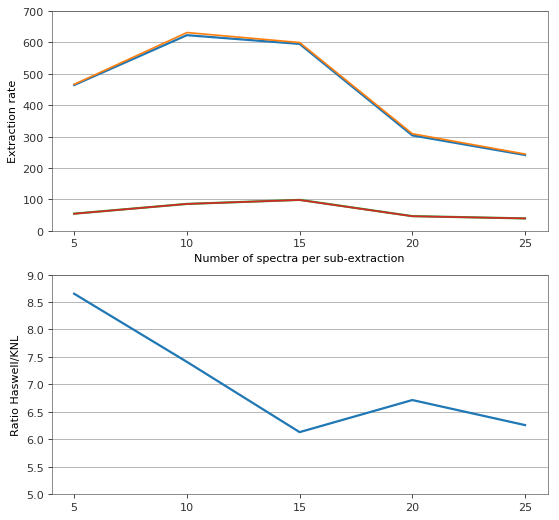

In [22]:
figure(figsize=(8,8))
subplot(211)
plot(nspec, rate_hsw_idp, lw=2, label='Haswell IDP')
plot(nspec, rate_hsw_ana, label='Haswell Anaconda')
plot(nspec, rate_knl_idp, lw=2, label='KNL IDP')
plot(nspec, rate_knl_ana, label='KNL Anaconda')
xticks(nspec)
xlabel('Number of spectra per sub-extraction')
ylabel('Extraction rate')
ylim(0,700)
grid(axis='y')

subplot(212)
plot(nspec, rate_hsw_ana / rate_knl_ana, lw=2)
xticks(nspec)
ylabel('Ratio Haswell/KNL')
ylim(5,9)
grid(axis='y')

best_ratio = max(rate_hsw_ana) / max(rate_knl_ana)
print('max(Haswell) / max(KNL) = {:.1f}'.format(best_ratio))